In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [2]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b', 'orange'
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.3)
  plt.legend()
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
  plt.savefig("word2vec-tsne", dpi = 600)          
  plt.show()
  return vecs_2d

### Data loading & processing

In [3]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.wv.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut
    
    """
    all_sims =  model.similar_by_vector(gender_vector, topn = len(model.wv.vectors), restrict_vocab=None)
    pos,neg,neut = [], [], []
    for sim in all_sims:
        w,score = sim
        if score > 3*eps:
            pos.append(sim)
        elif score < - 0.5*3*eps:
            neg.append(sim)
        elif abs(score) < eps:
            neut.append(sim)

    group1 = [random.choice(pos) for i in range(n)]
    group2 = [random.choice(neg) for i in range(n)]
    group3 = [random.choice(neut) for i in range(n)]
    group1 = sorted(group1, key = lambda pair: -pair[1])
    group2 = sorted(group2, key = lambda pair: -pair[1])
    group3 = sorted(group3, key = lambda pair: -pair[1])
    
    return group1, group2, group3
    """
def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs

""" 
def groups_by_neighbors(gender_vector, model: Word2VecKeyedVectors, n = 2500):

    biases = []
    words = list(model.wv.vocab.keys())
    for v,w in tqdm.tqdm(zip(model.wv.vectors, words), ascii = True, total = len(words)):
            
        bias =  get_bias_by_neighbors(model, v, gender_direction, topn = 100)
        biases.append((w, bias))
        #print((w,bias))
        
    pos,neg,neut = [], [], []
    
    eps = 0.25
    
    for word_and_bias in biases:
        w,bias = word_and_bias
        if bias > 0.5 + eps:
            pos.append(word_and_bias)
        elif bias < 0.5 - eps:
            neg.append(word_and_bias)
        elif abs(bias - 0.5) < eps/2:
            neut.append(word_and_bias)

    group1 = [random.choice(pos) for i in range(n)]
    group2 = [random.choice(neg) for i in range(n)]
    group3 = [random.choice(neut) for i in range(n)]
    group1 = sorted(group1, key = lambda pair: -pair[1])
    group2 = sorted(group2, key = lambda pair: -pair[1])
    group3 = sorted(group3, key = lambda pair: -pair[1])
    
    return group1, group2, group3        
"""        
    
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [4]:
# 150k top vectors (without gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.with_gendered.glove.txt")

# only gendered vectors

model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.glove.txt")

gender_direction = model_gendered["he"] - model_gendered["she"]
#gender_direction = model_gendered["he"] + model_gendered["man"] + model_gendered["boy"] + model_gendered["him"] - (model_gendered["she"] + model_gendered["woman"] + model_gendered["girl"] + model_gendered["her"])
gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)


masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = 25000)
#masc_words_and_scores , fem_words_and_scores, neut_words_and_scores = groups_by_neighbors(gender_direction, model, n=5000)    

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
#fem_scores = [-x for x in fem_scores]
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)

n = 3000
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:75])
print("LAST MASC")
print(masc_words[-75:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:75])
print("LAST FEM")
print(fem_words[-75:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:75])


TOP MASC
('drafted', 'qb', 'soriano', 'himself', 'cardinals', 'giants', 'he', 'bullpen', 'sabean', 'jagr', 'muhammad', 'alou', 'rangers', 'defensive', 'draft', 'belichick', 'rookie', 'ratzinger', 'obp', 'santonio', 'muhammed', 'yankees', 'outfielder', 'preached', 'playmaker', 'lineman', 'offensive', 'wr', 'steelers', 'redskins', 'rushers', 'his', 'punter', 'anquan', 'boldin', 'bochy', 'caesarea', 'nfl', 'umenyiora', 'laurinaitis', 'flacco', 'rc', 'eusebius', 'packers', 'lhp', 'homers', 'mitre', 'linebacker', 'rhp', 'manny', 'colts', 'ahl', 'elway', 'mcgwire', 'balmer', 'athanasius', 'bulls', 'pujols', 'disciples', 'chiefs', 'pitches', 'prophet', 'freeney', 'faneca', 'mvp', 'offense', 'ladainian', 'quarterback', 'wideout', 'lefty', 'players', 'hitters', 'dumervil', 'offseason', 'harmison')
LAST MASC
('jackson', 'shoup', 'brautigan', 'lenny', 'thhe', 'drum', 'maximization', 'therm', 'practises', 'seizing', 'sito', 'virginians', 'bander', 'fruitvale', 'awb', 'limped', 'lazar', 'arbitraril

In [5]:
print(np.mean(masc_scores))
print(np.mean(fem_scores))
print(np.mean(neut_scores))
print(masc_scores[-1])
print(fem_scores[-1])
print(neut_scores[-1])

0.11354103037804365
0.09341366603851319
0.0017645427008348524
0.07842518389225006
0.04460563510656357
-0.029999323189258575


### Perform train-dev-test split

In [6]:
X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = -np.ones(fem_vecs.shape[0], dtype = int)
y_neut = np.zeros(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 29379; Dev size: 12591; Test size: 27980


### Debias

In [7]:
REGRESSION = False
NUM_CLASSES = 3
EPSILON = 0.015

classifier_class = svm_classifier.SVMClassifier
num_classifiers = 15
input_dim = 300
is_autoregressive = True
min_accuracy = 0.0 #((1./NUM_CLASSES) + EPSILON) if not REGRESSION else 0.07
add_noise = False
random_sample = False
siamese = False
siamese_dim = 1
REGULARIZATION = "l2"

""" 
P = debias.get_debiasing_projection(classifier_class, num_classifiers, input_dim, 
                                    is_autoregressive, min_accuracy, X_train, Y_train,
                                    X_dev, Y_dev, add_noise, random_sample, REGRESSION,
                                    siamese, REGULARIZATION)
"""
gender_clf = LinearSVC
params = {'max_iter': 30000, 'fit_intercept': False, 'class_weight': None, "dual": False}
n = 35 # test: 25
min_acc = 0
P = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev, noise=False, random_subset = 1,
                                       Y_train_main=Y_train, Y_dev_main=Y_train, 
                                        by_class = False)

  3%|▎         | 1/35 [00:02<01:39,  2.94s/it]

Iteration 0, Accuracy: 0.9355889127154317


  6%|▌         | 2/35 [00:06<01:42,  3.09s/it]

Iteration 1, Accuracy: 0.5343499324914621


  9%|▊         | 3/35 [00:09<01:41,  3.16s/it]

Iteration 2, Accuracy: 0.46001111905329206


 11%|█▏        | 4/35 [00:12<01:36,  3.12s/it]

Iteration 3, Accuracy: 0.4212532761496307


 14%|█▍        | 5/35 [00:15<01:29,  2.98s/it]

Iteration 4, Accuracy: 0.3912318322611389


 17%|█▋        | 6/35 [00:17<01:20,  2.78s/it]

Iteration 5, Accuracy: 0.3788420300214439


 20%|██        | 7/35 [00:20<01:15,  2.69s/it]

Iteration 6, Accuracy: 0.36136923199110477


 23%|██▎       | 8/35 [00:22<01:07,  2.50s/it]

Iteration 7, Accuracy: 0.36399015169565563


 26%|██▌       | 9/35 [00:24<01:01,  2.36s/it]

Iteration 8, Accuracy: 0.3603367484711302


 29%|██▊       | 10/35 [00:26<00:57,  2.29s/it]

Iteration 9, Accuracy: 0.36073385751727427


 31%|███▏      | 11/35 [00:32<01:19,  3.30s/it]

Iteration 10, Accuracy: 0.36692875863712177


 34%|███▍      | 12/35 [00:39<01:46,  4.65s/it]

Iteration 11, Accuracy: 0.36653164959097767


 37%|███▋      | 13/35 [00:41<01:23,  3.79s/it]

Iteration 12, Accuracy: 0.35851004685886745


 40%|████      | 14/35 [00:43<01:06,  3.19s/it]

Iteration 13, Accuracy: 0.36970852196013027


 43%|████▎     | 15/35 [00:45<00:55,  2.75s/it]

Iteration 14, Accuracy: 0.3618457628464776


 46%|████▌     | 16/35 [00:46<00:46,  2.42s/it]

Iteration 15, Accuracy: 0.35962195218807086


 49%|████▊     | 17/35 [00:48<00:39,  2.20s/it]

Iteration 16, Accuracy: 0.34913827336986736


 51%|█████▏    | 18/35 [00:51<00:39,  2.35s/it]

Iteration 17, Accuracy: 0.34286395044079104


 54%|█████▍    | 19/35 [00:55<00:46,  2.91s/it]

Iteration 18, Accuracy: 0.34532602652688427


 57%|█████▋    | 20/35 [00:57<00:37,  2.52s/it]

Iteration 19, Accuracy: 0.3489794297514097


 60%|██████    | 21/35 [00:58<00:30,  2.20s/it]

Iteration 20, Accuracy: 0.35676276705583354


 63%|██████▎   | 22/35 [00:59<00:25,  1.97s/it]

Iteration 21, Accuracy: 0.3566039234373759


 66%|██████▌   | 23/35 [01:01<00:21,  1.77s/it]

Iteration 22, Accuracy: 0.3545389563974267


 69%|██████▊   | 24/35 [01:02<00:16,  1.53s/it]

Iteration 23, Accuracy: 0.35517433087125727


 71%|███████▏  | 25/35 [01:03<00:13,  1.39s/it]

Iteration 24, Accuracy: 0.3542212691605115


 74%|███████▍  | 26/35 [01:04<00:11,  1.28s/it]

Iteration 25, Accuracy: 0.3587483122865539


 77%|███████▋  | 27/35 [01:04<00:08,  1.08s/it]

Iteration 26, Accuracy: 0.3590659995234691


 80%|████████  | 28/35 [01:05<00:06,  1.04it/s]

Iteration 27, Accuracy: 0.3500119132713843


 83%|████████▎ | 29/35 [01:06<00:04,  1.20it/s]

Iteration 28, Accuracy: 0.3516003494559606


 86%|████████▌ | 30/35 [01:06<00:03,  1.37it/s]

Iteration 29, Accuracy: 0.3229290763243587


 89%|████████▊ | 31/35 [01:07<00:02,  1.52it/s]

Iteration 30, Accuracy: 0.3587483122865539


 91%|█████████▏| 32/35 [01:07<00:01,  1.68it/s]

Iteration 31, Accuracy: 0.3587483122865539


 94%|█████████▍| 33/35 [01:07<00:01,  1.79it/s]

Iteration 32, Accuracy: 0.3587483122865539


 97%|█████████▋| 34/35 [01:08<00:00,  1.85it/s]

Iteration 33, Accuracy: 0.3587483122865539


100%|██████████| 35/35 [01:08<00:00,  1.97s/it]

Iteration 34, Accuracy: 0.3587483122865539


### Test the quality of the debiasing.

#### Perform t-sne

1025
975


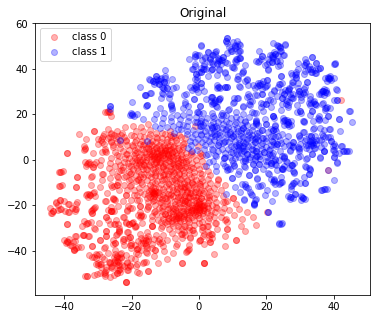

1025
975


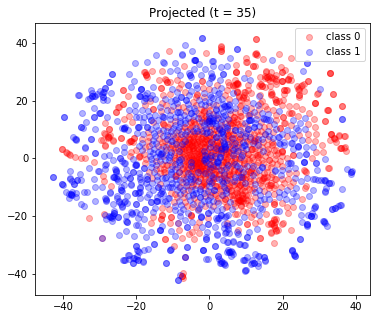

V-measure-before: 0.817235781517761
V-measure-after: 0.020117048171119287


In [8]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)
    
#def to_integer(arr, eps = 0.03):
#    return np.array([1 if x > eps else (-1 if x < -eps else 0) for x in arr])
    
#Y_dev = to_integer(Y_dev) #Y_dev > 0
#Y_train = to_integer(Y_train)

# remove the neutral class

X_dev = X_dev[Y_dev != 0]
X_train = X_train[Y_train != 0]
Y_dev = Y_dev[Y_dev != 0]
Y_train = Y_train[Y_train != 0]

M =  2000

tsne_before = tsne_by_gender(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original")
X_dev_cleaned = X_dev.dot(P)
X_test_cleaned = X_test.dot(P)
X_trained_cleaned = X_train.dot(P)
#all_biased_cleaned = all_significantly_biased_vecs.dot(P)
tsne_after = tsne_by_gender(all_significantly_biased_vecs[:M].dot(P), all_significantly_biased_labels[:M], title = "Projected (t = 35)")

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

NUM_CLUSTERS = [2,10,25,100]
""" 
print("CALCULATING BIAS BY CLUSTERING (WITH K-MENAS)")
for num_clusters in NUM_CLUSTERS:
    print("NUM CLUSTERS = {}".format(num_clusters))
    purity_original = perform_purity_test(X_dev, k = num_clusters, labels_true = Y_dev)
    purity_after = perform_purity_test(X_dev_cleaned, k = num_clusters, labels_true = Y_dev)
    print("Purity in original space: {}".format(purity_original))
    print("Purity after debiasing projection: {}".format(purity_after))
"""
print("V-measure-before: {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after: {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

#### Train a nonlinear classifier for gender prediction.

In [9]:
nonlinear_clf = SVC(kernel = "rbf")
print("Before, rbf-svm:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

print("After, linear:")
linear_clf = LinearSVC()
linear_clf.fit(X_trained_cleaned, Y_train)
print(linear_clf.score(X_dev_cleaned, Y_dev))


print("After, rbf-svm:")
nonlinear_clf = SVC(kernel = "rbf")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

print("After, mlp:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

Before, rbf-svm:
1.0
After, linear:
0.5002765792676181
After, rbf-svm:
0.5729616107976546
After, mlp:
0.796990817568315


#### project on the gender direction

In [10]:
masc_vecs_cleaned = masc_vecs.dot(P)
fem_vecs_cleaned = fem_vecs.dot(P)

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec.dot(P)).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec.dot(P)).mean()))      

masc-bias-before: 0.7433770895004272
masc-bias-after: -0.00013444516452444712
fem-bias-before: -0.6116276979446411
fem-bias-after: -0.00013826310483576804


#### calculate the similarity matrix before and after

In [11]:

def get_distance_matrix(vecs: np.ndarray):

  distances = sklearn.metrics.pairwise_distances(vecs, vecs, metric="cosine")
  return distances

def plot_distance(distance_before, distance_after):

    idx = distance_before < 0.75 # we are only interested in the relatively close words

    distance_before = distance_before.copy()[idx]
    distance_after = distance_after.copy()[idx]
    
    chosen = np.random.rand(len(distance_before)) < 0.01
    before = distance_before[chosen]
    after = distance_after[chosen]
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("distnace before")
    plt.ylabel("distance after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after):

    K = 50
    most_similar_idx_before = distance_before.argsort(axis = 0)[:K].T
    most_similar_idx_after = distance_after.argsort(axis = 0)[:K].T
    data = []
    
    for i, (bias, dis_before, dis_after) in enumerate(tqdm.tqdm(zip(bias_before, distance_before, distance_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = (most_similar_idx_before[i] == most_similar_idx_after[i]).sum() 
        intersection = idx_before.intersection(idx_after)
        data.append((abs(bias), 1 - len(intersection)/K))
        #data.append((abs(bias), 1 - intersection/K))
        
    plt.xlabel("change in similarity (% of of top-{}-similar that changed)".format(K))
    plt.ylabel("bias before")
    biases, sims = zip(*data)    
    plt.plot(sims, biases, linestyle="None", marker = "*", alpha = 0.1)

    plt.show()
    print("Correlation: {}".format(pearsonr(biases, sims)[0]))

#### Plot similarity before vs. similarity after, and change of similarity vs. bias before

In [12]:
""" 
prop = 0.08
idx = np.random.rand(vecs.shape[0]) < prop
vecs_sample = vecs[idx]
words_sample = np.array(words, dtype = "object")[idx]

vecs_sample_cleaned = vecs_sample.dot(P)

distance_before = get_distance_matrix(vecs_sample)
distance_after = get_distance_matrix(vecs_sample_cleaned)

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
sample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)
sample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)

bias_before = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample)[0] #sample_normalized.dot(gender_unit_vec)
bias_after = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample_cleaned)[0] #sample_normalized.dot(gender_unit_vec)

plot_distance(distance_before.reshape(-1), distance_after.reshape(-1))
plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after)

# plot bias histograms before and after

# all vecs

plt.hist(bias_before, bins = 25, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after, bins = 25, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, all vecs")
plt.show()

# most originally biased (dev set)

bias_before_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev)[0]
bias_after_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev.dot(P))[0]

plt.hist(bias_before_dev, bins = 35, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after_dev, bins = 35, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, dev set (most biased originally)")
plt.show()
"""

' \nprop = 0.08\nidx = np.random.rand(vecs.shape[0]) < prop\nvecs_sample = vecs[idx]\nwords_sample = np.array(words, dtype = "object")[idx]\n\nvecs_sample_cleaned = vecs_sample.dot(P)\n\ndistance_before = get_distance_matrix(vecs_sample)\ndistance_after = get_distance_matrix(vecs_sample_cleaned)\n\ngender_unit_vec = gender_direction/np.linalg.norm(gender_direction)\nsample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)\nsample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)\n\nbias_before = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample)[0] #sample_normalized.dot(gender_unit_vec)\nbias_after = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample_cleaned)[0] #sample_normalized.dot(gender_unit_vec)\n\nplot_distance(distance_before.reshape(-1), distance_after.reshape(-1))\nplot_similarity_change_vs_original_bias(bias_b

In [13]:
vecs_cleaned = vecs.dot(P)
save_in_word2vec_format(vecs_cleaned, words, "../data/embeddings/vecs.150k.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.150k.cleaned.txt")

150000it [00:37, 3951.98it/s]


#### calcualte the similarity of female-stereotyped words to 'girlish', before and after

In [14]:

w = "girlish"
k = 5000

random_fem_words = np.random.choice(fem_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_fem_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_fem_words]

print("Similarity of female-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


Similarity of female-stereotyped words to 'girlish' before: 0.0657164677977562; similarity after: -0.0009310243767686188


### Calcualte bias-by-clustering

In [15]:
def numerical_bias_by_clustering(model_before, model_after, masc_words, fem_words, k):
    
    scores_before, scores_after = [], []
    all_biased = masc_words.union(fem_words)
    
    for w in all_biased:
        
        most_similar_before = model_before.most_similar(w, topn = k)
        most_similar_before, _ = zip(*most_similar_before)

        most_similar_after = model_after.most_similar(w, topn = k)
        most_similar_after, _ = zip(*most_similar_after)
        
        neighbors_biased_before = len([w for w in most_similar_before if w in all_biased])
        neighbors_biased_after = len([w for w in most_similar_after if w in all_biased])
        scores_before.append(neighbors_biased_before)
        scores_after.append(neighbors_biased_after)
    print("avg. number of biased neighbors before: {}; after: {}".format(np.mean(scores_before), np.mean(scores_after)))
    
    
    
    

In [16]:
#numerical_bias_by_clustering(model, model_cleaned, set(masc_words), set(fem_words), k = 1000)

#### print the most similar words to random words before and after (to make sure we didn't damage the space too much)

In [17]:
words_chosen = np.random.choice(words[:15000] , size = 100)
topn = 10

for w in words_chosen:
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, _ = zip(*words_and_sims_before)
    words_after, _ = zip(*words__and_sims_after)
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")

w: vmware
 most-similar-before: ('vsphere', 'virtualization', 'citrix', 'esxi', 'esx', 'netapp', 'virtualisation', 'virtualbox', 'vcenter', 'vm')
 most-similar-after: ('vsphere', 'virtualization', 'esxi', 'esx', 'citrix', 'vcenter', 'virtualisation', 'xenserver', 'virtualbox', 'netapp')
----------------------------------
w: tailor
 most-similar-before: ('tailored', 'tailoring', 'tailors', 'bespoke', 'customised', 'customize', 'customized', 'cater', 'customise', 'dressmaker')
 most-similar-after: ('tailors', 'tailoring', 'tailored', 'customised', 'customize', 'dressmaker', 'bespoke', 'customized', 'customise', 'seamstress')
----------------------------------
w: asap
 most-similar-before: ('please', 'pls', 'anytime', 'plz', 'soon', 'tomorrow', 'anyways', 'anyway', 'hopefully', 'urgently')
 most-similar-after: ('urgently', 'promptly', 'pls', 'please', 'plz', 'soon', 'lmk', 'immediatly', 'anytime', 'plzz')
----------------------------------
w: sunflower
 most-similar-before: ('safflower', 

w: pierce
 most-similar-before: ('allen', 'smith', 'harris', 'howard', 'crawford', 'marion', 'williams', 'davis', 'anderson', 'parker')
 most-similar-after: ('tamora', 'rajon', 'garnett', 'snohomish', 'brosnan', 'rondo', 'puyallup', 'dade', 'pierces', 'pierced')
----------------------------------
w: remove
 most-similar-before: ('removing', 'removed', 'removes', 'rid', 'delete', 'eliminate', 'add', 'replace', 'removal', 'prevent')
 most-similar-after: ('removing', 'removes', 'delete', 'removed', 'rid', 'uninstall', 'eliminate', 'discard', 'disable', 'filterissue')
----------------------------------
w: adwords
 most-similar-before: ('adsense', 'ppc', 'adword', 'seo', 'google', 'keyword', 'adcenter', 'analytics', 'advertisers', 'marketing')
 most-similar-after: ('adsense', 'adword', 'ppc', 'adcenter', 'keyword', 'seo', 'google', 'clickbank', 'marketing', 'wordtracker')
----------------------------------
w: panama
 most-similar-before: ('rica', 'nicaragua', 'peru', 'guatemala', 'belize', 

w: wounded
 most-similar-before: ('injured', 'killed', 'soldiers', 'soldier', 'mortally', 'civilians', 'wounds', 'wounding', 'troops', 'casualties')
 most-similar-after: ('injured', 'mortally', 'wounding', 'killed', 'soldiers', 'maimed', 'soldier', 'wounds', 'civilians', 'servicemen')
----------------------------------
w: sole
 most-similar-before: ('heel', 'discretion', 'shoe', 'soles', 'purpose', 'toe', 'shoes', 'insole', 'proprietor', 'outsole')
 most-similar-after: ('outsole', 'heel', 'insole', 'soles', 'proprietorship', 'proprietor', 'discretion', 'toe', 'midsole', 'vibram')
----------------------------------
w: preserve
 most-similar-before: ('preserving', 'conserve', 'maintain', 'protect', 'preserves', 'preservation', 'retain', 'restore', 'preserved', 'safeguard')
 most-similar-after: ('preserving', 'conserve', 'preserves', 'maintain', 'protect', 'preservation', 'retain', 'restore', 'safeguard', 'uphold')
----------------------------------
w: senses
 most-similar-before: ('sense

w: somehow
 most-similar-before: ('seems', 'obviously', 'actually', 'something', 'apparently', 'perhaps', 'unfortunately', 'nothing', 'maybe', 'seemed')
 most-similar-after: ('someway', 'something', 'magically', 'suppose', 'maybe', 'actually', 'miraculously', 'seems', 'perhaps', 'else')
----------------------------------
w: regulatory
 most-similar-before: ('regulation', 'compliance', 'regulations', 'oversight', 'governmental', 'administrative', 'legislative', 'regulators', 'legislation', 'requirements')
 most-similar-after: ('regulation', 'compliance', 'regulations', 'oversight', 'harmonization', 'governmental', 'mhra', 'approvals', 'harmonisation', 'regulators')
----------------------------------
w: myspace
 most-similar-before: ('facebook', 'friendster', 'youtube', 'twitter', 'layouts', 'yahoo', 'orkut', 'bebo', 'site', 'pic')
 most-similar-after: ('friendster', 'xanga', 'facebook', 'backrounds', 'orkut', 'bebo', 'layouts', 'livejournal', 'photobucket', 'plurk')
--------------------

### bias by profession experiment

In [18]:
def get_bias_by_neighbors(model, model_cleaned, gendered_words, v, gender_direction): 
    
    neighbors = model_cleaned.similar_by_vector(v, topn=100) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    return bias

def bias_by_profession(model, model_cleaned, gender_direction, P, masc_words):
    
    with codecs.open("../data/lists/professions.json") as f:
        professions_and_scores = json.load(f)

    professions = [p[0] for p in professions_and_scores]
    #print(professions)
    professions = list(filter(lambda p: p in model.wv, professions))
    vecs = np.array([model[p] for p in professions])
    vecs_cleaned = vecs.dot(P)
    bias_vals = np.array([model.cosine_similarities(gender_direction,vecs)])[0]
    #bias_vals_after = np.array([model.cosine_similarities(gender_direction,vecs_cleaned)])[0]
    bias_by_neighbors_after = np.array([get_bias_by_neighbors(model, model_cleaned, masc_words, v, gender_direction) for v in vecs_cleaned])
    bias_by_neighbors_before = np.array([get_bias_by_neighbors(model, model, masc_words, v, gender_direction) for v in vecs])

    #plt.ylim([np.min(bias_vals), np.max(bias_vals)])
    plt.plot(bias_vals, bias_by_neighbors_after, marker = "o", linestyle = "none", color = "red", label = "after", alpha = 0.25)
    plt.plot(bias_vals, bias_by_neighbors_before, marker = "o", linestyle = "none", color = "blue", label = "before", alpha = 0.25)
    
    word_idx_high = np.argsort(bias_vals)[:4] 
    word_idx_low = np.argsort(bias_vals)[-4:]
    word_idx_middle_low = np.argsort(bias_vals)[-55:-51]
    word_idx_middle_high = np.argsort(bias_vals)[51:55]
    words_biased_fem = [professions[i] for i in word_idx_high]
    words_biased_masc = [professions[i] for i in word_idx_low]
    mid_low = [professions[i] for i in word_idx_middle_low]
    mid_high = [professions[i] for i in word_idx_middle_high]
    words = words_biased_masc + words_biased_fem + mid_low + mid_high
    
    for w in words:
        i = professions.index(w)
        x1,y1 = bias_vals[i],bias_by_neighbors_after[i]
        plt.annotate(w , (x1,y1), size = 8, color = "red")
        x2,y2 = bias_vals[i],bias_by_neighbors_before[i]
        plt.annotate(w, (x2,y2), size = 8, color = "blue")
        #plt.arrow(x2,y2,x1-x2,y1-y2, width = 0.0005)
        
    plt.legend()
    plt.xlabel("bias-by-PROJECTION of the professions before")
    plt.ylabel("bias-by-NEIGHBORS")
    plt.title("projection bias before vs. neighbors bias before/after \n(# neighbors closer to 'she' then 'he')")
    plt.show()
    
    print("Correlation before: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_before)))
    print("Correlation after: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_after)))

        

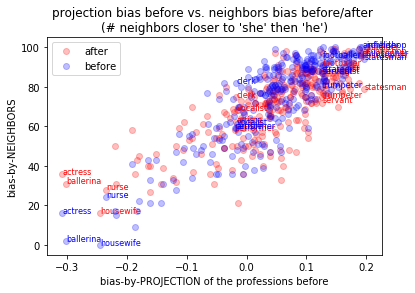

Correlation before: 0.8524125165100177, p-value: 2.2680951373250805e-83
Correlation after: 0.7679446080448006, p-value: 7.446794147354234e-58


In [19]:
bias_by_profession(model, model_cleaned, gender_direction, P, None)

In [20]:
"""
for i, (w,v,l) in enumerate(zip(all_significantly_biased_words,all_biased_cleaned,
                               all_significantly_biased_labels)):
    
    neighbors = model_cleaned.similar_by_vector(v, topn = 6, restrict_vocab=None)[1:]
    print(w, neighbors)
    print("===========================================")
 """

'\nfor i, (w,v,l) in enumerate(zip(all_significantly_biased_words,all_biased_cleaned,\n                               all_significantly_biased_labels)):\n    \n    neighbors = model_cleaned.similar_by_vector(v, topn = 6, restrict_vocab=None)[1:]\n    print(w, neighbors)\n    print("===========================================")\n '

### word association tests

In [21]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools


def s_word(w, A, B, model, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(model.similarity(w,a))
    for b in B:
        mean_b.append(model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, model, all_s_words):
    
    total = 0
    for x in X:
        x_sim = s_word(x, A, B, model, all_s_words)
        total += x_sim
    for y in Y:
        y_sim =  s_word(y, A, B, model, all_s_words)
        total -= y_sim
    
    #print(x_sim, y_sim)
        
    return total


def p_value_exhust(X, Y, A, B, model):
    
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, model, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    for subset in tqdm.tqdm(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    #print ('num of samples', total)
    return larger/float(total)


def p_value_sample(X, Y, A, B, model):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, model, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [22]:
# Experiment 1

A = ['John', 'Paul', 'Mike', 'Kevin', 'Steve', 'Greg', 'Jeff', 'Bill']
B = ['Amy', 'Joan', 'Lisa', 'Sarah', 'Diana', 'Kate', 'Ann', 'Donna']
A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print (p_value_exhust(A, B, C, D, model_cleaned))

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print (p_value_exhust(A, B, E, F, model_cleaned))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print (p_value_exhust(A, B, G, H, model_cleaned))

100%|██████████| 12870/12870 [00:00<00:00, 164625.97it/s]

0.39044289044289043
0.39813519813519815
0.482983682983683


### Compare with debiasing on specific directions

In [23]:
words = [("he", "she"), ("man", "woman"), ("boy", "girl"), ("king", "queen"), ("him", "her"), ("father", "mother"), ("grandfather", "grandmother")]

In [24]:
vecs = [ [model[p[1]] - model[p[0]]] for p in words]
P_by_words = debias.debias_by_specific_directions(vecs, 300) # projection matrix generated by zeroing the above directions
X_dev_cleaned = X_dev.dot(P_by_words)
X_train_cleaned = X_train.dot(P_by_words)

In [25]:
clf = LinearSVC()
clf.fit(X_train_cleaned, Y_train)
print(clf.score(X_dev_cleaned, Y_dev))

0.7297267396835934


A linear classifier is still able to recover the gender with no-random